# Reproducing previous Machine-learning paper

The first attempt at the Met Office to apply Machine Learning techniques to the problem of missing metadata in the XBT dataset was done by Thomas P. Leahy and Francesc Llopis working with Niall Robinson and Matt Palmer. 

https://journals.ametsoc.org/doi/full/10.1175/JTECH-D-18-0012.1?af=R&mobileUi=0

They trained neural network classifier on the XBT data, using the same features, country, date of profile and maximum depth, as the iMeta algorithm. They did not train on the whole dataset, but rather year by year.
In this notebook we are replicating the results in the published paper as a starting point, and then consider some basic extensions, like training on larger subsets or the whole dataset, using additional features and doing hyper parameter tuning.

In [2]:
import os
import sys
from pathlib import Path
import functools

import pandas
import numpy

import matplotlib
import matplotlib.pyplot

In [3]:
import ipywidgets
import time

In [4]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.metrics

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [7]:
from xbt_dataset import XbtDataset

In [8]:
from imeta import imeta_classification, XBT_MAX_DEPTH

In [9]:
# Set up some site specific parameters for the notebook
environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_with_imeta',
    'pangeo': '/data/misc/xbt-data/csv_with_imeta/',
}
env_date_ranges = {
    'MO_scitools': (1996,2015),
    'pangeo': (1966,2015)
}

In [10]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['country','max_depth', 'year']
train_fraction = 0.75
test_fraction = 1 - train_fraction

## Preparing the data

In [11]:
xbt_full_dataset = XbtDataset(env_data_dirs[environment], env_date_ranges[environment])

load the following features: ['country', 'institute', 'platform', 'cruise_number', 'instrument', 'imeta_applied', 'max_depth', 'lat', 'lon', 'id', 'date']


In [12]:
xbt_labelled = xbt_full_dataset.filter_obs('labelled', 'labelled')

extracting labelled


## Calculating iMeta results

For comparison, we calculate the output from the intelligent metadata algorithm to compare results with ML artificial neaural network results.


In [13]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)


In [14]:
imeta_model = imeta_classes.apply(lambda t1: t1[0]).astype('category', catergories=xbt_labelled['model'].cat.categories)
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1]).astype('category', catergories=xbt_labelled['manufacturer'].cat.categories)

In [29]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})').astype('category', catergories=xbt_labelled['instrument'].cat.categories)

## Training and evaluating neural networks for each year

To replicate the paper results, we use the scikit-learn MLPClassifier class, training one classifier for year in the XBT dataset.  For each of those years, we split the profiles into training and test sets, train the classifier, then calculate the classification metrics on the train and test sets. The main metric used in the paper was recall.
The results are then collated in a dataframe, together with the classification metrics for the iMeta classification output.

First add a train/test split field to the labelled data frame. Thi is so we can easily either train and evaluate on different periods, e.g. train on whole dataset and look at performance per year

In [15]:
xbt_train_all, xbt_test_all = xbt_labelled.train_test_split(split_on_feature='year')

Create the feature encoders on the whole dataset so comparisons are possible. This will create encoders based on the whole datasert. When we subset the data using filter_obs or filter_features, the encoders will be passed to the subset and used there. This way we know whatever subset we process, the encodings will be the same so the results can be easily compared.

In [16]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [17]:
def classify_subset(classifier_class, xbt_subset, x_features, y_feature):
    xbt_train_year, xbt_test_year = xbt_subset.train_test_split()
    (X_train, _, _, _) = xbt_train_year.filter_features(x_features).get_ml_dataset()
    (X_test, _, _, _) = xbt_test_year.filter_features(x_features).get_ml_dataset()
    (y_train, _, _, _) = xbt_train_year.filter_features([y_feature]).get_ml_dataset()
    (y_test, _, _, _) = xbt_test_year.filter_features([y_feature]).get_ml_dataset()
    clf_mlp1 = classifier_class()
    clf_mlp1.fit(X_train, y_train)
    y_res_train = clf_mlp1.predict(X_train)
    metric_train = sklearn.metrics.precision_recall_fscore_support(y_train, y_res_train)
    y_res_test = clf_mlp1.predict(X_test)
    metric_test = sklearn.metrics.precision_recall_fscore_support(y_test, y_res_test)
    return {'classifier':clf_mlp1,'metrics_train': metric_train, 'metrics_test': metric_test}

In [22]:
classify_nnet = functools.partial(classify_subset, sklearn.neural_network.MLPClassifier)

In [23]:
results_model1 = {}
results_manufacturer1 = {}
results_instrument1 = {} 

In [24]:
training_progress = ipywidgets.IntProgress(min=env_date_ranges[environment][0],
                                           max= env_date_ranges[environment][1],
                                          description='Training',
                                          bar_style='info')
training_progress

IntProgress(value=1966, bar_style='info', description='Training', max=2015, min=1966)

In [25]:
training_progress.value = env_date_ranges[environment][0]
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]+1):
    xbt_subset = xbt_labelled.filter_obs('year', year)
    try:
        results_model1[year] = classify_nnet(xbt_subset, input_feature_names, 'model')
    except Exception as e1:
        print(f'Error processing model {year} - {e1}')
    try:
        results_manufacturer1[year] = classify_nnet(xbt_subset, input_feature_names, 'manufacturer')
    except Exception as e1:
        print(f'Error processing manufacturer {year} - {e1}')
    training_progress.value = year
    try:
        results_instrument1[year] = classify_nnet(xbt_subset, input_feature_names, 'instrument')
    except Exception as e1:
        print(f'Error processing manufacturer {year} - {e1}')
    training_progress.value = year
    
    


Error processing model 2015 - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
Error processing manufacturer 2015 - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
Error processing manufacturer 2015 - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


In [28]:
eval_progress = ipywidgets.IntProgress(min=env_date_ranges[environment][0],
                                           max= env_date_ranges[environment][1],
                                          description='Evaluating',
                                          bar_style='info')
eval_progress

IntProgress(value=1966, bar_style='info', description='Evaluating', max=2015, min=1966)

In [33]:
imeta_results = []
eval_progress.value = env_date_ranges[environment][0]
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]+1):
    xbt_subset = xbt_labelled.filter_obs('year',year)
    xbt_model1, enc_model1, _, _ = xbt_subset.filter_features(['model']).get_ml_dataset()
    enc_model1 = enc_model1['model']
    xbt_manufacturer1, enc_manuf1, _, _ = xbt_subset.filter_features(['manufacturer']).get_ml_dataset()
    enc_manuf1 = enc_manuf1['manufacturer']
    xbt_instrument1, enc_instr1, _, _ = xbt_subset.filter_features(['instrument']).get_ml_dataset()
    enc_instr1 = enc_instr1['instrument']
    
    imeta_output = imeta_classes[xbt_labelled.xbt_df.year == year]
    imeta_instr1 = enc_instr1.transform(pandas.DataFrame({'imeta_instrument': imeta_instrument[xbt_labelled.xbt_df.year == year]}) )
    imeta_model1 = enc_model1.transform(pandas.DataFrame({'imeta_model': imeta_model[xbt_labelled.xbt_df.year == year]}) )
    imeta_manuf1 = enc_manuf1.transform(pandas.DataFrame({'imeta_manufacturer': imeta_manufacturer[xbt_labelled.xbt_df.year == year]}) )
    
    if enc_model1.categories_[0].shape[0] == 1:
        (im_pr_model, im_rec_model, im_f1_model, im_sup_model) = (1.0, 1.0, 1.0, xbt_subset.shape[0])
    else:
        (im_pr_model, im_rec_model, im_f1_model, im_sup_model) = sklearn.metrics.precision_recall_fscore_support(xbt_model1, imeta_model1,average='micro')
    if enc_manuf1.categories_[0].shape[0] == 1:
        (im_pr_manuf, im_rec_manuf, im_f1_manuf, im_sup_manuf) = (1.0, 1.0, 1.0, xbt_subset.shape[0])
    else:
        (im_pr_manuf, im_rec_manuf, im_f1_manuf, im_sup_manuf) = sklearn.metrics.precision_recall_fscore_support(xbt_manufacturer1, imeta_manuf1,average='micro')
    (im_pr_instr, im_rec_instr, im_f1_instr, im_sup_instr) = sklearn.metrics.precision_recall_fscore_support(xbt_instrument1, imeta_instr1,average='micro')

    imeta_results += [{'year': year,
                       'imeta_model_recall': im_rec_model,
                       'imeta_model_precision': im_pr_model,
                       'imeta_manuf_recall': im_rec_manuf,
                       'imeta_manuf_precision': im_pr_manuf,
                       'imeta_instr_recall': im_rec_instr,
                       'imeta_instr_precision': im_pr_instr,
                       
                      }]
    eval_progress.value = year
    

In [34]:
imeta_res_df = pandas.DataFrame.from_records(imeta_results)

## Classification Performance

The results for classification of model and manufacturer separately is shown below. We see that recall is better for manufacturer than model, which is not surprising as it is principally a 2 class problem, with almost all profles being from probes manufactured by Sippican or TSK.

The current iMeta performance does not match that shown in the paper and needs further investigation.

In [41]:
res_manuf_df = pandas.DataFrame({
'year' :list( results_manufacturer1.keys()),
'recall_manuf_train_per_year' : [
    numpy.sum(numpy.array(results_manufacturer1[year1]['metrics_train'][1])
    * numpy.array(results_manufacturer1[year1]['metrics_train'][3])) 
    / sum(results_manufacturer1[year1]['metrics_train'][3])  
    for year1 in results_manufacturer1.keys()],
'precision_manuf_train_per_year' : [
    numpy.sum(numpy.array(results_manufacturer1[year1]['metrics_train'][0])
    * numpy.array(results_manufacturer1[year1]['metrics_train'][3])) 
    / sum(results_manufacturer1[year1]['metrics_train'][3])  
    for year1 in results_manufacturer1.keys()],

'recall_manuf_test_per_year' : [
    numpy.sum(numpy.array(results_manufacturer1[year1]['metrics_test'][1])
    * numpy.array(results_manufacturer1[year1]['metrics_test'][3])) 
    / sum(results_manufacturer1[year1]['metrics_test'][3])  
    for year1 in results_manufacturer1.keys()],
'precision_manuf_test_per_year' : [
    numpy.sum(numpy.array(results_manufacturer1[year1]['metrics_test'][0])
    * numpy.array(results_manufacturer1[year1]['metrics_test'][3])) 
    / sum(results_manufacturer1[year1]['metrics_test'][3])  
    for year1 in results_manufacturer1.keys()],
})
res_manuf_df.sort_values(by='year', inplace=True)

In [37]:
res_model_df = pandas.DataFrame({
'year' : list(results_model1),
'recall_model_train_per_year' : [
    numpy.sum(numpy.array(results_model1[year1]['metrics_train'][1])
    * numpy.array(results_model1[year1]['metrics_train'][3])) 
    / sum(results_model1[year1]['metrics_train'][3])  
    for year1 in results_model1.keys()],
'precision_model_train_per_year' : [
    numpy.sum(numpy.array(results_model1[year1]['metrics_train'][0])
    * numpy.array(results_model1[year1]['metrics_train'][3])) 
    / sum(results_model1[year1]['metrics_train'][3])  
    for year1 in results_model1.keys()],

'recall_model_test_per_year' : [
    numpy.sum(numpy.array(results_model1[year1]['metrics_test'][1])
    * numpy.array(results_model1[year1]['metrics_test'][3])) 
    / sum(results_model1[year1]['metrics_test'][3])  
    for year1 in results_model1.keys()],
'precision_model_test_per_year' : [
    numpy.sum(numpy.array(results_model1[year1]['metrics_test'][0])
    * numpy.array(results_model1[year1]['metrics_test'][3])) 
    / sum(results_model1[year1]['metrics_test'][3])  
    for year1 in results_model1.keys()],
})
res_model_df.sort_values(by='year', inplace=True)

In [46]:
res_instr_df = pandas.DataFrame({
'year' :list( results_instrument1.keys()),
'recall_instr_train_per_year' : [
    numpy.sum(numpy.array(results_instrument1[year1]['metrics_train'][1])
    * numpy.array(results_instrument1[year1]['metrics_train'][3])) 
    / sum(results_instrument1[year1]['metrics_train'][3])  
    for year1 in results_instrument1.keys()],
'precision_instr_train_per_year' : [
    numpy.sum(numpy.array(results_instrument1[year1]['metrics_train'][0])
    * numpy.array(results_instrument1[year1]['metrics_train'][3])) 
    / sum(results_instrument1[year1]['metrics_train'][3])  
    for year1 in results_instrument1.keys()],
'recall_instr_test_per_year' : [
    numpy.sum(numpy.array(results_instrument1[year1]['metrics_test'][1])
    * numpy.array(results_instrument1[year1]['metrics_test'][3])) 
    / sum(results_instrument1[year1]['metrics_test'][3])  
    for year1 in results_instrument1.keys()],
'precision_instr_test_per_year' : [
    numpy.sum(numpy.array(results_instrument1[year1]['metrics_test'][0])
    * numpy.array(results_instrument1[year1]['metrics_test'][3])) 
    / sum(results_instrument1[year1]['metrics_test'][3])  
    for year1 in results_instrument1.keys()],    
})
res_instr_df.sort_values(by='year', inplace=True)

In [47]:
results_df = pandas.merge(res_model_df, res_manuf_df).merge(res_instr_df).merge(imeta_res_df).merge(
    pandas.DataFrame.from_dict({
        'year': xbt_labelled['year'].value_counts(sort=False).index,
        'num_samples': xbt_labelled['year'].value_counts(sort=False).values,
    }))

## Paper plots

### Figure 1
* plot 1 - Recall for NN and iMeta per year
* plot 2 - percentage imporvement in recall per year 

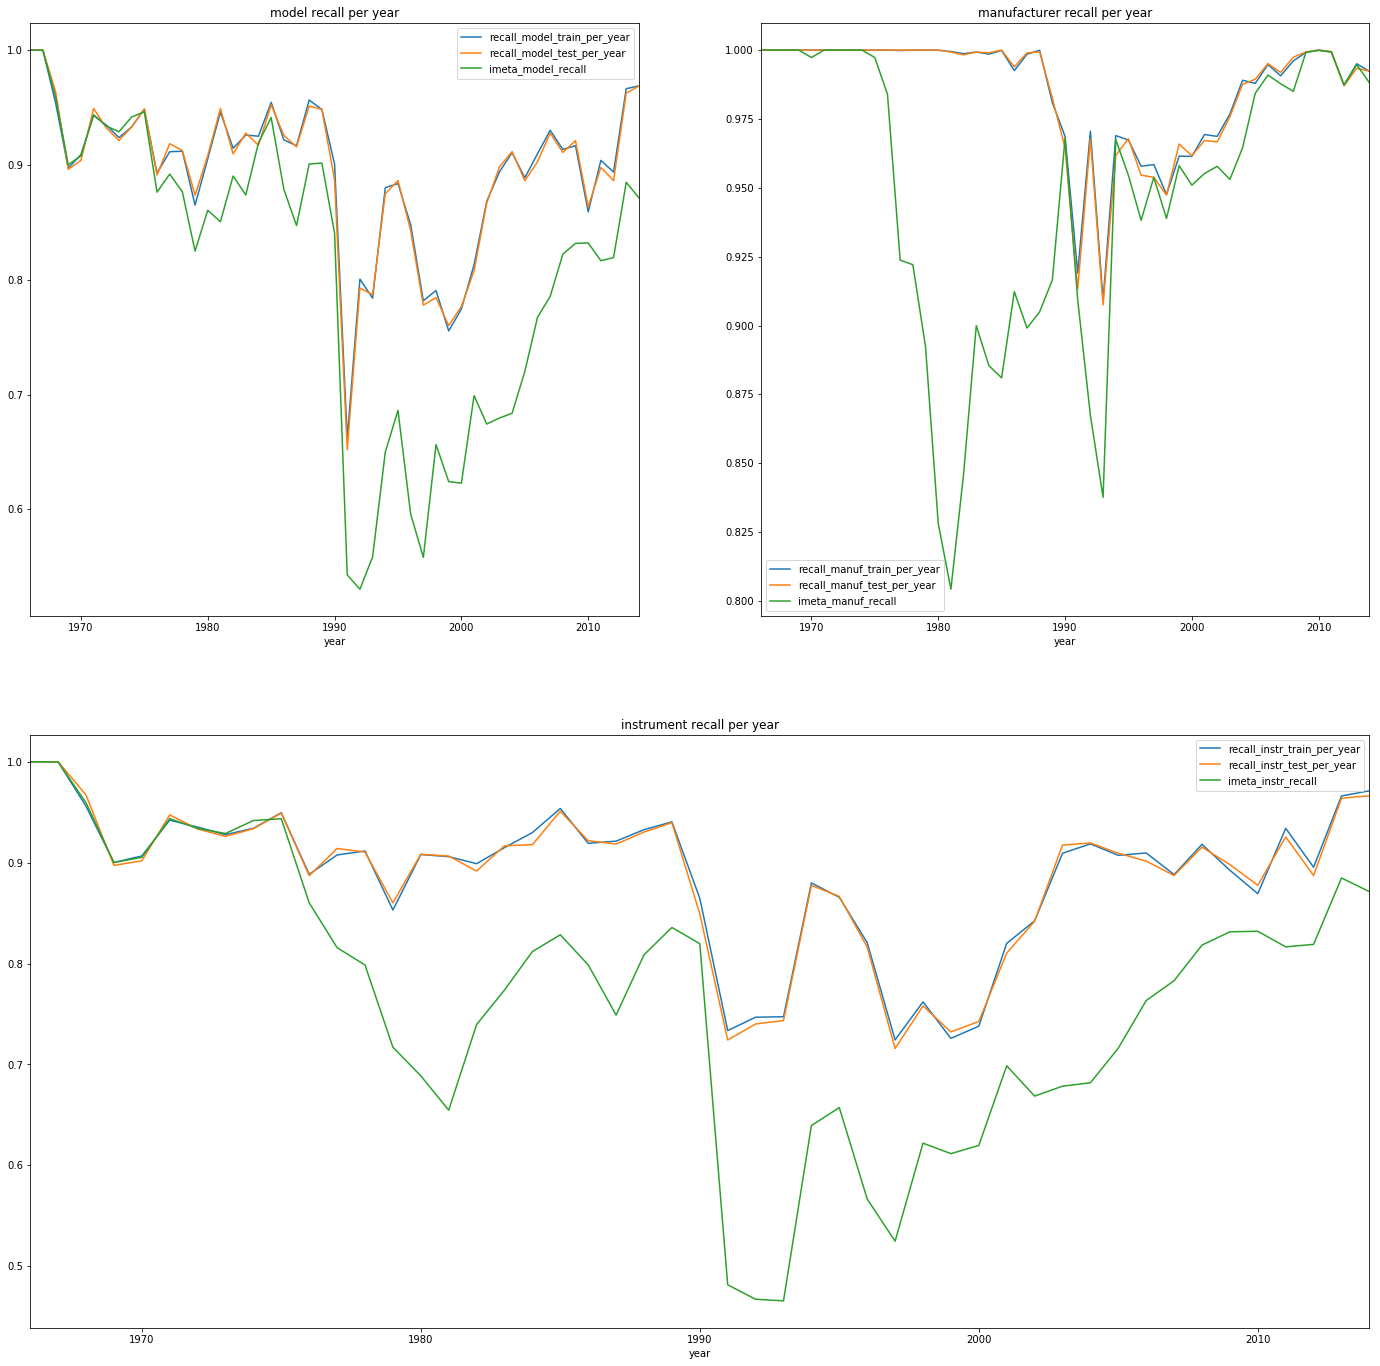

In [52]:
fig_recall_per_year = matplotlib.pyplot.figure('fig_recall_per_year', figsize=(24, 24))
ax_recall_model = fig_recall_per_year.add_subplot(221, title='model recall per year')
_ = results_df.plot.line(ax=ax_recall_model, x='year',y=['recall_model_train_per_year','recall_model_test_per_year','imeta_model_recall'] )
ax_recall_manuf = fig_recall_per_year.add_subplot(222, title='manufacturer recall per year')
_ = results_df.plot.line(ax=ax_recall_manuf, x='year',y=['recall_manuf_train_per_year','recall_manuf_test_per_year','imeta_manuf_recall'], )
ax_recall_instr = fig_recall_per_year.add_subplot(212, title='instrument recall per year')
_ = results_df.plot.line(ax=ax_recall_instr, x='year',y=['recall_instr_train_per_year','recall_instr_test_per_year','imeta_instr_recall'], )


In [54]:
results_df['improvement'] = results_df.apply(lambda r1: ((r1['recall_instr_test_per_year'] /  r1['imeta_instr_recall'])-1)*100.0 , axis=1)

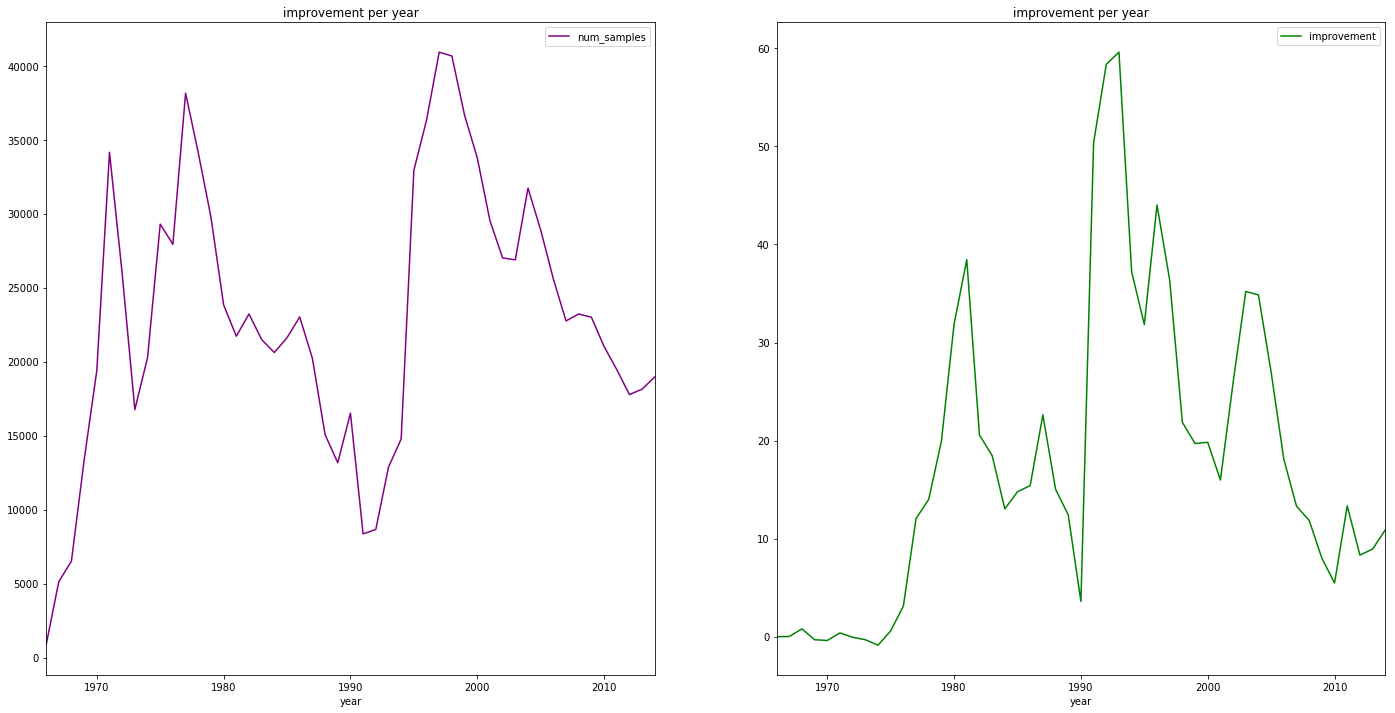

In [55]:
fig_num_samples_per_year = matplotlib.pyplot.figure('fig_num_samples_per_year', figsize=(24,12))
ax_num_samples = fig_num_samples_per_year.add_subplot(121, title='improvement per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['num_samples'],c='purple' )
ax_num_samples = fig_num_samples_per_year.add_subplot(122, title='improvement per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['improvement'], c='green' )